In [1]:
import os
import json
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.gaussian_process.kernels import Matern
from GPy.mappings.constant import Constant
from GPy.kern import Matern52
from GPy.models import GPRegression

from scipy.special import ndtr
from scipy.stats import norm

warnings.filterwarnings('ignore')
# plt.style.use('classic')
plt.style.use('seaborn-paper')
%matplotlib inline

In [2]:
# plotting styles

def nnsvm(rcParams, i=0):
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = 'Ubuntu'
    rcParams['font.monospace'] = 'Ubuntu Mono'
    rcParams['font.size'] = 12 + i
    rcParams['axes.labelsize'] = 12 + i
    rcParams['axes.labelweight'] = 'normal'
    rcParams['xtick.labelsize'] = 10 + i
    rcParams['ytick.labelsize'] = 10 + i
    rcParams['legend.fontsize'] = 12 + i
    rcParams['figure.titlesize'] = 14 + i
    rcParams['lines.linewidth']= 2.7
    rcParams['axes.titlesize'] = 14 + i
alpha_plt = 0.4 # beautification
    
# gifs stuff
gifDir = 'MAB_gifs'
os.makedirs(gifDir, exist_ok=True)
delay = 80

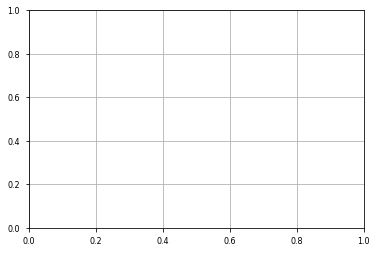

In [3]:
plt.gca().grid()

In [4]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
        
    ax.grid(alpha=0.25)

    return ax

In [5]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

In [6]:
nnsvm(plt.rcParams, -2)

In [7]:
x = np.atleast_2d(np.linspace(0, 6, 600)).T

In [8]:
# kernel = Matern(length_scale=1.0)
# kernel = None

y_pred, sigma = 5*np.ones(x.shape).flatten(), 1.1*np.ones(x.shape).flatten()

In [9]:
train_X = np.atleast_2d([0.5, 0.12]).T
train_y = f(train_X)

In [10]:
def gp_creator(x, y, val = 5):
    y.resize(x.shape[0], 1)
    ker = Matern52(x.shape[1], ARD=True, variance=1)
#     print (x, x.mean())
    mean_fn = Constant(x.shape[1], 1, value=val)
    gp = GPRegression(x, y, kernel=ker, noise_var=0,
                      mean_function = mean_fn)
    gp.optimize()
    return gp

# Create Posterior

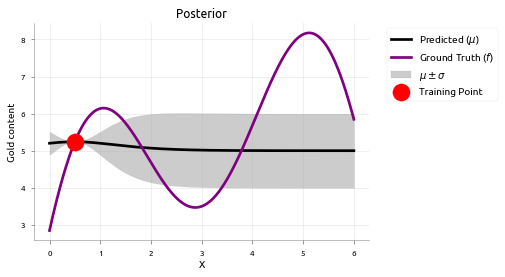

In [11]:
train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).flatten()
gp = gp_creator(train_X, train_y)
# gp.fit(train_X, train_y)
# gp.optimize()
y_pred, sigma = [t.flatten() for t in gp.predict(x)]
plt.plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
plt.plot(x, f(x), 'purple', label=r'Ground Truth ($f$)')
plt.xlabel("X")
plt.title("Posterior")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=alpha_plt, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='red', s=300, zorder=10, label='Training Point')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())
# plt.savefig('MAB_gifs/posterior.svg', bbox_inches="tight")

# Creating some samples

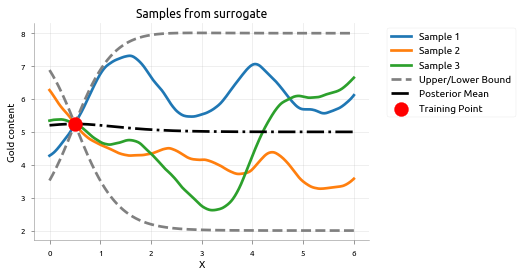

In [12]:
# for i in range(4):
#     y_pred, sigma = [t.flatten() for t in gp.predict(x)]
#     plt.plot(x, y_pred, label=f'Sample {i}')
np.random.seed(0)
testX = x
samples = 3
posteriorTestY = gp.posterior_samples_f(testX, full_cov=True, size=samples)
simY, simMse = gp.predict(testX)
posteriorTestY = posteriorTestY.reshape((posteriorTestY.shape[0], samples))
for i in range(samples):
    plt.plot(testX, posteriorTestY[:, i], label=f"Sample {i+1}")
plt.plot(testX, simY - 3 * simMse ** 0.5, 
         c='grey', linestyle= '--', label = "Upper/Lower Bound")
plt.plot(testX, simY + 3 * simMse ** 0.5, 
         c='grey', linestyle= '--')
plt.plot(testX, simY, 'k', linestyle='-.', label="Posterior Mean")
plt.scatter(train_X, train_y, color='red', s=200, zorder=10, label='Training Point')
plt.xlabel("X")
plt.title("Samples from surrogate")
plt.ylabel("Gold content")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())
plt.savefig('MAB_gifs/thompson.svg', bbox_inches="tight")

Below we can see that this choice of `lam = 5` is still a little smaller than we like (we would like to see that we get to exploit the location where the gold is the most.).

![](MAB_gifs/mab-gp-5.gif)